In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc



# Load dataset
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Method Overview
We’re using an SVM model to predict whether someone has heart disease or not. Basically, SVM looks for the best possible boundary that separates people with heart disease from those without it. 

To make sure we picked the best version of the model, we tested different types of kernels — like linear, RBF, polynomial, and sigmoid — and chose the one that performed best using repeated stratified k-fold cross-validation.

After that, we built our final model using a three-layer split: 60% of the data for training, 20% for validation, and 20% for final testing. This helps make sure the model generalizes well and isn’t just overfitting.

## Data preparation
To prepare the data, we applied one-hot encoding to categorical features and standardized the numerical ones. 

In [2]:
# Separate features and target
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

In [3]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [4]:
# Create feature transformers
# OneHotEncoder for categorical features
# StandardScaler for numerical features
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
])

## Cross Validation test kernels
We tested four different kernels, linear, RBF, polynomial, and sigmoid, to see which one works best for predicting heart disease.

The RBF kernel came out on top in both accuracy and F1-score:
- Accuracy: 87.14%
- F1-score: 88.69%

That means it not only predicts correctly more often, but also performs better in balancing precision and recall, which is especially important when both false positives and false negatives matter. So for our final model, we decided to go with the RBF kernel.


In [5]:
# Find the best kernels using cross-validation
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

# Scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}

for k in kernels:
    model = Pipeline([
        ('preprocess', preprocessor),
        ('svm', SVC(kernel=k))
    ])
    
    scores = cross_validate(
        model, X, y,
        scoring=scoring,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42),
        return_train_score=False
    )
    
    acc_mean = scores['test_accuracy'].mean()
    f1_mean = scores['test_f1'].mean()
    
    kernel_results[k] = {'accuracy': acc_mean, 'f1': f1_mean}
    print(f"{k:<8} → Accuracy: {acc_mean:.4f} | F1-score: {f1_mean:.4f}")

# Select best kernels based on each metric
best_acc_kernel = max(kernel_results, key=lambda k: kernel_results[k]['accuracy'])
best_f1_kernel = max(kernel_results, key=lambda k: kernel_results[k]['f1'])

# Print both results
print(f"Best kernel based on Accuracy: '{best_acc_kernel}' with accuracy = {kernel_results[best_acc_kernel]['accuracy']:.4f}")
print(f"Best kernel based on F1-score: '{best_f1_kernel}' with F1 = {kernel_results[best_f1_kernel]['f1']:.4f}")


linear   → Accuracy: 0.8644 | F1-score: 0.8795
rbf      → Accuracy: 0.8714 | F1-score: 0.8869
poly     → Accuracy: 0.8678 | F1-score: 0.8817
sigmoid  → Accuracy: 0.7766 | F1-score: 0.8012
Best kernel based on Accuracy: 'rbf' with accuracy = 0.8714
Best kernel based on F1-score: 'rbf' with F1 = 0.8869


## Construct final model
For our final SVM model, we used a three-way data split: 60% of the data went into training, 20% into validation, and 20% into testing. That gave us 550 samples for training, and 184 each for validation and test.

The model got about 85% accuracy on the validation set, which helped us make sure it wasn’t overfitting.

On the final test set, the model achieved 90% accuracy overall. It had strong precision and recall for both classes — around 89% for people without heart disease, and about 91% recall for those with it.

This tells us the model is well balanced and reliable. It’s especially good at catching positive cases of heart disease, which is important in healthcare.

In [6]:
best_kernel = 'rbf'

# Create pipeline with preprocessing and SVM
model = Pipeline([
    ('preprocess', preprocessor),
    ('svm', SVC(kernel = best_kernel, probability=True))
])

In [7]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=100
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=100
)

print(f"Train size: {len(X_train)} | Val size: {len(X_val)} | Test size: {len(X_test)}")

Train size: 550 | Val size: 184 | Test size: 184


In [8]:
# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak'])])),
                ('svm', SVC(probability=True))])

In [9]:
# Model sanity check
val_score = model.score(X_val, y_val)
print(f"Validation Accuracy: {val_score:.4f}")

Validation Accuracy: 0.8533


In [10]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



## Tuning hyperparameters
Even though our original SVM model already performed well — with 90% accuracy and strong F1-scores — we still did hyperparameter tuning to make sure we weren’t missing any improvements.

We tested different combinations of C and gamma using GridSearchCV. The best combo was C = 1 and gamma = 0.1, giving us a slightly better F1-score of 0.891. A heatmap confirmed that this was consistently the top-performing setting.

After tuning, the model’s performance on the test set stayed just as strong — with balanced precision and recall for both classes. That shows our original model was already solid, and tuning helped us double-check that we weren’t overfitting.

Even when we expanded the parameter search space, we didn’t see further improvement, suggesting the model likely reached its optimal performance given the data.

Running Grid Search for: Small Grid
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.1}
Best F1-score: 0.8909652847473761


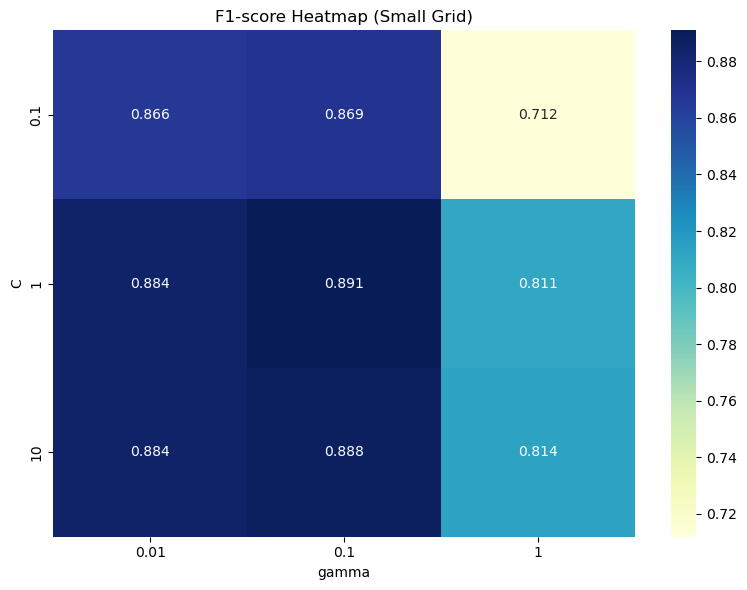

Running Grid Search for: Expanded Grid
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.1}
Best F1-score: 0.8909652847473761


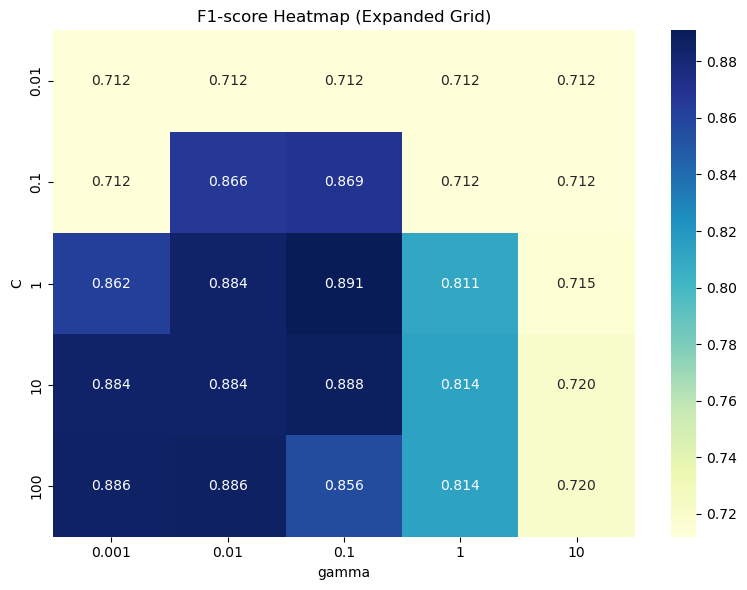

In [16]:
param_grids = {
    "Small Grid": {
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1]
    },
    "Expanded Grid": {
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__gamma': [0.001, 0.01, 0.1, 1, 10]
    }
}

for grid_name, param_grid in param_grids.items():
    print(f"Running Grid Search for: {grid_name}")
    
    model = Pipeline([
        ('preprocess', preprocessor),
        ('svm', SVC(kernel=best_kernel, probability=True))
    ])

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best F1-score:", grid_search.best_score_)
    
    # Heatmap
    results = pd.DataFrame(grid_search.cv_results_)
    pivot = results.pivot(
        index='param_svm__C',
        columns='param_svm__gamma',
        values='mean_test_score'
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f"F1-score Heatmap ({grid_name})")
    plt.xlabel("gamma")
    plt.ylabel("C")
    plt.tight_layout()
    plt.show()


## Visuializations
All three visualizations confirm that our tuned SVM model is not only accurate but also well-balanced and reliable in both class-specific and overall performance.

## Confusion Matrix
As shown in the confusion matrix, our model correctly classified 93 out of 102 heart disease cases, and 72 out of 82 no-disease cases — with only 19 misclassifications in total.

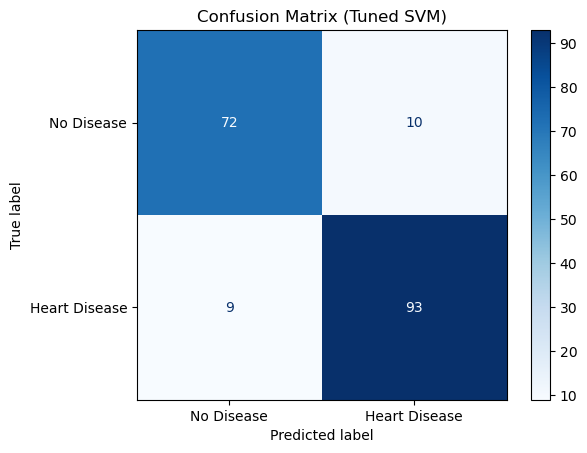

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Heart Disease'])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Tuned SVM)")
plt.show()

## Bar plot (Precision / Recall / F1-score)
Precision, recall, and F1-score are all close to 0.9 for both classes, with slightly better recall on the positive class — meaning the model is especially good at catching heart disease cases.

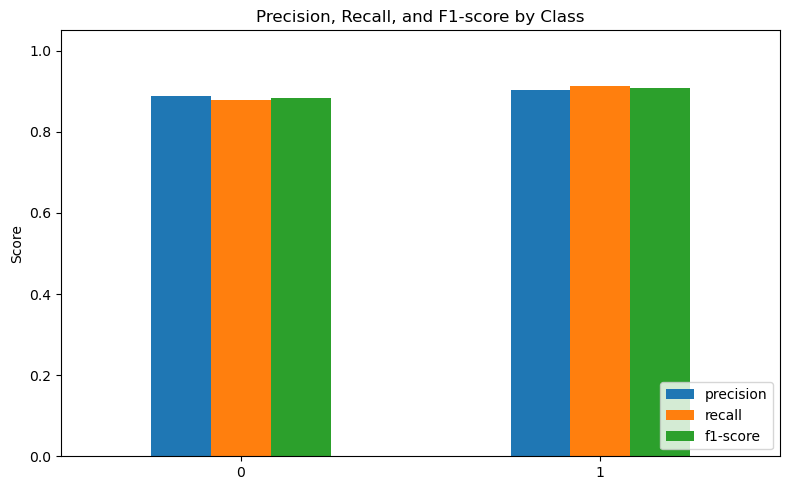

In [13]:
# Construct dataframe
report_dict = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).T.iloc[:2, :3]  

df.plot(kind='bar', figsize=(8, 5))
plt.ylim(0, 1.05)
plt.title("Precision, Recall, and F1-score by Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Roc curve
The ROC curve shows an AUC of 0.962, which confirms that the model has excellent overall discrimination. The model is highly effective at distinguishing between the two classes.

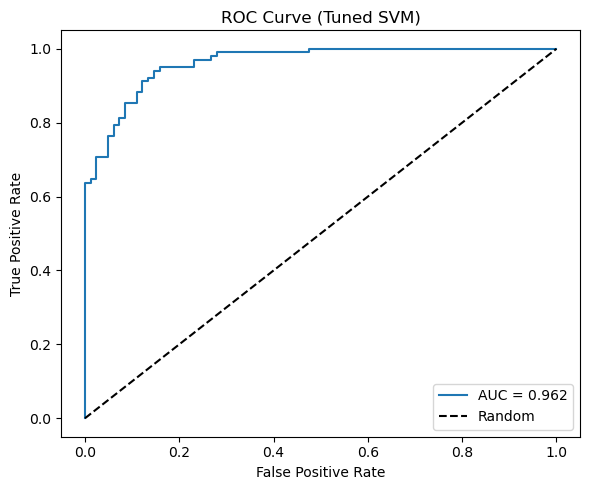

In [14]:
y_score = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned SVM)")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion
The SVM model showed strong, balanced performance. It remained robust even after kernel comparison and hyperparameter tuning.

However, to better understand which model works best overall, it’s important to compare SVM with other methods like Random Forest and ANN. By analyzing their respective strengths and limitations, we can identify the most suitable approach for predicting heart disease in real-world applications.